**数据预处理**

jupyter实现远程连接
```
nohup jupyter notebook --ip=10.5.0.22 &

```
[剪枝量化代码](https://github.com/nephashi/DeepCompression)


In [1]:
import os
import shutil

def reorg_cifar10_data(data_dir, label_file, train_dir, test_dir, input_dir, valid_ratio):
    # 读取训练数据标签。
    with open(os.path.join(data_dir, label_file), 'r') as f:
        # 跳过文件头行（栏名称）。
        lines = f.readlines()[1:]
        tokens = [l.rstrip().split(',') for l in lines]
        idx_label = dict(((int(idx), label) for idx, label in tokens))
    labels = set(idx_label.values())

    num_train = len(os.listdir(os.path.join(data_dir, train_dir)))
    num_train_tuning = int(num_train * (1 - valid_ratio))
    assert 0 < num_train_tuning < num_train
    num_train_tuning_per_label = num_train_tuning // len(labels)
    label_count = dict()

    def mkdir_if_not_exist(path):
        if not os.path.exists(os.path.join(*path)):
            os.makedirs(os.path.join(*path))

    # 整理训练和验证集。
    for train_file in os.listdir(os.path.join(data_dir, train_dir)):
        idx = int(train_file.split('.')[0])
        label = idx_label[idx]
        mkdir_if_not_exist([data_dir, input_dir, 'train_valid', label])
        shutil.copy(os.path.join(data_dir, train_dir, train_file),
                    os.path.join(data_dir, input_dir, 'train_valid', label))
        if label not in label_count or label_count[label] < num_train_tuning_per_label:
            mkdir_if_not_exist([data_dir, input_dir, 'train', label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                        os.path.join(data_dir, input_dir, 'train', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            mkdir_if_not_exist([data_dir, input_dir, 'valid', label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                        os.path.join(data_dir, input_dir, 'valid', label))

    # 整理测试集。
    mkdir_if_not_exist([data_dir, input_dir, 'test', 'unknown'])
    for test_file in os.listdir(os.path.join(data_dir, test_dir)):
        shutil.copy(os.path.join(data_dir, test_dir, test_file),
                    os.path.join(data_dir, input_dir, 'test', 'unknown'))

In [2]:
prepocess = False
if prepocess:
    demo = False
    if demo:
        # 注意：此处使用小训练集为便于网页编译。Kaggle的完整数据集应包括5万训练样本。
        train_dir = 'train_tiny'
        # 注意：此处使用小测试集为便于网页编译。Kaggle的完整数据集应包括30万测试样本。
        test_dir = 'test_tiny'
        # 注意：此处相应使用小批量。对Kaggle的完整数据集可设较大的整数，例如128。
        batch_size = 1
    else:
        train_dir = 'train'
        test_dir = 'test'
        batch_size = 128

    data_dir = '/home/dragon/code/gluon/cifar10/'
    label_file = 'trainLabels.csv'
    input_dir = 'train_valid_test'
    valid_ratio = 0.1
    reorg_cifar10_data(data_dir, label_file, train_dir, test_dir, input_dir, valid_ratio)


使用新的数据和训练方式来做

# 定义网络结构

In [3]:
from mxnet.gluon import nn
from mxnet import nd
from mxnet import init
class Residual(nn.HybridBlock):
    def __init__(self, channels, same_shape=True):
        super(Residual, self).__init__()
        self.same_shape = same_shape
        strides = 1 if same_shape else 2
        bn1 = nn.BatchNorm()
        conv1 = nn.Conv2D(channels , 3, padding=1, strides=strides,use_bias=False)
        bn2 = nn.BatchNorm()
        rl1 = nn.Activation(activation='relu')
        conv2 = nn.Conv2D(channels,kernel_size=3,strides=1,padding=1,use_bias=False)
        bn3 = nn.BatchNorm()
        self.net = nn.HybridSequential()
        self.net.add(bn1,conv1,bn2,rl1,conv2,bn3)
        if not same_shape:
            conv3 = nn.Conv2D(channels,kernel_size=1,strides=strides)
            self.net.add(conv3)

    def hybrid_forward(self,F,x):
        out = x
        for l in self.net[:-1]:
            out = l(out)
        if not self.same_shape:
            x=self.net[-1](x)
        else:
            out = self.net[-1](out)
        return F.relu(out+x)
        #return mx.sym.relu(out+x)



In [4]:
class Resnet_tea(nn.HybridBlock):
    def __init__(self, num_classes, verbose=False):
        super(Resnet_tea, self).__init__()
        self.verbose = verbose
        with self.name_scope():
            b1 = nn.HybridSequential()
            b1.add(
                nn.BatchNorm(),
                nn.Conv2D(32,kernel_size=3,strides=1,use_bias=False)
            )
            num_res = 5
            b2 = nn.HybridSequential()
            #b2.add(Residual(64,same_shape=False))
            for i in range(num_res+1):
                b2.add(Residual(32))
            b3 = nn.HybridSequential()
            b3.add(
                Residual(64,same_shape=False)
            )
            for i in range(num_res):
                b3.add(Residual(64))
            b4 = nn.HybridSequential()
            b4.add(
                Residual(128,same_shape=False)
            )
            for i in range(num_res):
                b4.add(Residual(128))
            b5 = nn.HybridSequential()
            b5.add(
                nn.BatchNorm(),
                nn.Activation('relu'),
                nn.AvgPool2D(pool_size=8),
                nn.Dense(num_classes)
            )
            self.net = nn.HybridSequential()
            self.net.add(b1,b2,b3,b4,b5)   
    def hybrid_forward(self, F, x):
        out = x
        for i, b in enumerate(self.net):
            out = b(out)
            if self.verbose:
                print('Block %d output: %s' % (i + 1, out.shape))
        return out        
            


In [5]:
import datetime
#writer = SummaryWriter()
import matplotlib.pyplot as plt
#%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
def get_acc(output, label):
    pred = output.argmax(1, keepdims=True)
    correct = (pred == label).sum()
    return correct.asscalar()

def train(net, train_data, valid_data, num_epochs, lr, wd, ctx, lr_decay):
    trainer = gluon.Trainer(
        net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    print("Start training on ", ctx)
    train_accs = []
    test_accs = []
    losses_all = []

    prev_time = datetime.datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        correct = 0
        total = 0
        if epoch == 60 or epoch == 120:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for data, label in train_data:
            bs = data.shape[0]
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss = criterion(output, label)
            loss.backward()
            trainer.step(bs)
            train_loss += nd.mean(loss).asscalar()
            correct += get_acc(output, label)
            total += bs
        #writer.add_scalars('loss', {'train': train_loss / len(train_data)}, epoch)
        #writer.add_scalars('acc', {'train': correct / total}, epoch)
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_correct = 0
            valid_total = 0
            valid_loss = 0
            for data, label in valid_data:
                bs = data.shape[0]
                data = data.as_in_context(ctx)
                label = label.as_in_context(ctx)
                output = net(data)
                loss = criterion(output, label)
                valid_loss += nd.mean(loss).asscalar()
                valid_correct += get_acc(output, label)
                valid_total += bs
            valid_acc = valid_correct / valid_total
            #writer.add_scalars('loss', {'valid': valid_loss / len(valid_data)}, epoch)
            #writer.add_scalars('acc', {'valid': valid_acc}, epoch)
            epoch_str = ("Epoch %d. Train Loss: %f, Train acc %f, Valid Loss: %f, Valid acc %f, "
                         % (epoch, train_loss / len(train_data),
                            correct / total, valid_loss / len(valid_data), valid_acc))
            train_accs.append(correct / total)
            test_accs.append(valid_acc)
            losses_all.append(train_loss / len(train_data))
        else:
            epoch_str = ("Epoch %d. Loss: %f, Train acc %f, "
                         % (epoch, train_loss / len(train_data),
                            correct / total))
        prev_time = cur_time
        print(epoch_str + time_str + ', lr ' + str(trainer.learning_rate))
        show = True
    if show==True:
        plt.plot(losses_all)
        plt.plot(train_accs)
        plt.plot(test_accs)
        plt.legend(['loss','train','test'])
        plt.show()

In [6]:
def test(net, valid_data):
    valid_correct = 0
    valid_total = 0
    valid_loss = 0
    
    prev_time = datetime.datetime.now()
    for data, label in valid_data:
        bs = data.shape[0]
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        loss = criterion(output, label)
        valid_loss += nd.mean(loss).asscalar()
        valid_correct += get_acc(output, label)
        valid_total += bs
    valid_acc = valid_correct / valid_total
    cur_time = datetime.datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    test_str = "Valid Loss: %f, Valid acc %f" % (valid_loss / len(valid_data), valid_acc) 
    time_str = "Time %02d:%02d:%02d" % (h, m, s)
    print(test_str+time_str)


In [7]:
import mxnet as mx
from mxnet import image
from mxnet import nd, gluon, autograd, init
from mxnet.gluon.data.vision import ImageFolderDataset
from mxnet.gluon.data import DataLoader
from mxnet.gluon import nn
import numpy as np
import shutil
def transform_train(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')

def transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')



def try_gpu():
    """If GPU is available, return mx.gpu(0); else return mx.cpu()"""
    try:
        ctx = mx.gpu()
        _ = nd.array([0], ctx=ctx)
    except:
        ctx = mx.cpu()
    return ctx

In [8]:
batch_size = 256
train_ds = ImageFolderDataset('/home/dragon/code/gluon/cifar10/train_valid_test/train/', transform=transform_train)
valid_ds = ImageFolderDataset('/home/dragon/code/gluon/cifar10/train_valid_test/valid/', transform=transform_test)
train_data = DataLoader(train_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
valid_data = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, last_batch='keep')

In [13]:
model = Resnet_tea(10)
ctx = try_gpu()
model.initialize(ctx=ctx, init=mx.initializer.Xavier())
model.hybridize()
criterion = gluon.loss.SoftmaxCrossEntropyLoss()

('Start training on ', gpu(0))
Epoch 0. Train Loss: 1.626062, Train acc 0.395667, Valid Loss: 1.410667, Valid acc 0.498600, Time 00:03:14, lr 0.1
Epoch 1. Train Loss: 1.142722, Train acc 0.586556, Valid Loss: 1.087941, Valid acc 0.621400, Time 00:01:21, lr 0.1
Epoch 2. Train Loss: 0.871716, Train acc 0.692200, Valid Loss: 0.941418, Valid acc 0.678400, Time 00:01:24, lr 0.1
Epoch 3. Train Loss: 0.720427, Train acc 0.747689, Valid Loss: 0.785860, Valid acc 0.728000, Time 00:01:36, lr 0.1
Epoch 4. Train Loss: 0.631289, Train acc 0.778467, Valid Loss: 0.727280, Valid acc 0.761800, Time 00:01:37, lr 0.1
Epoch 5. Train Loss: 0.554566, Train acc 0.808244, Valid Loss: 0.592960, Valid acc 0.796600, Time 00:01:41, lr 0.1
Epoch 6. Train Loss: 0.504634, Train acc 0.825644, Valid Loss: 0.532167, Valid acc 0.820000, Time 00:01:41, lr 0.1
Epoch 7. Train Loss: 0.468367, Train acc 0.835978, Valid Loss: 0.539077, Valid acc 0.816800, Time 00:01:42, lr 0.1
Epoch 8. Train Loss: 0.434438, Train acc 0.848356

Epoch 71. Train Loss: 0.011284, Train acc 0.997022, Valid Loss: 0.292264, Valid acc 0.935200, Time 00:01:47, lr 0.01
Epoch 72. Train Loss: 0.010205, Train acc 0.997089, Valid Loss: 0.295241, Valid acc 0.935800, Time 00:01:42, lr 0.01
Epoch 73. Train Loss: 0.010481, Train acc 0.997133, Valid Loss: 0.293889, Valid acc 0.935400, Time 00:01:43, lr 0.01
Epoch 74. Train Loss: 0.008698, Train acc 0.997889, Valid Loss: 0.296788, Valid acc 0.934400, Time 00:01:46, lr 0.01
Epoch 75. Train Loss: 0.007873, Train acc 0.998133, Valid Loss: 0.312929, Valid acc 0.933200, Time 00:01:45, lr 0.01
Epoch 76. Train Loss: 0.008595, Train acc 0.997622, Valid Loss: 0.306996, Valid acc 0.936000, Time 00:01:46, lr 0.01
Epoch 77. Train Loss: 0.008040, Train acc 0.997800, Valid Loss: 0.311892, Valid acc 0.934800, Time 00:01:47, lr 0.01
Epoch 78. Train Loss: 0.007253, Train acc 0.998133, Valid Loss: 0.314595, Valid acc 0.932800, Time 00:01:45, lr 0.01
Epoch 79. Train Loss: 0.007637, Train acc 0.998000, Valid Loss: 

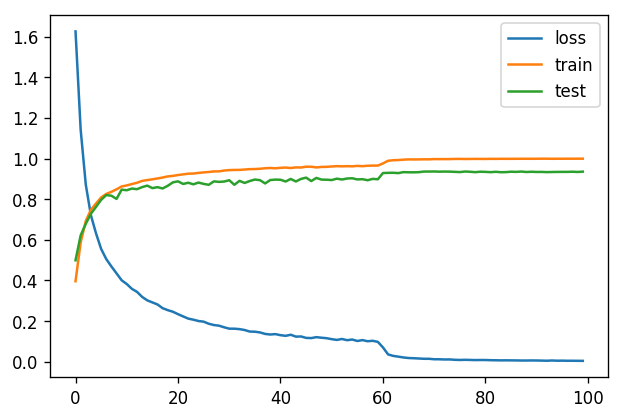

In [10]:
num_epochs = 100
lr = 0.1
wd = 1e-4
lr_decay = 0.1
criterion = gluon.loss.SoftmaxCrossEntropyLoss()
Train = True
if Train:
    train(model, train_data, valid_data, num_epochs, lr, wd, ctx, lr_decay)


### 保存训练后的教师网络

In [13]:
model.save_params('./model_compression/tea_rs38_93.params')

In [15]:
model.load_params('./model_compression/tea_rs38_93.params',ctx=ctx)

In [16]:
ll ./model_compression/tea_rs38_93.params

ls: 初始化月份字符串出错
-rw-rw-r-- 1 dragon 9053143 3鏈�20 20:00 ./model_compression/tea_rs38_93.params


In [17]:
test(model,valid_data)

Valid Loss: 0.340523, Valid acc 0.935400Time 00:00:03


**下面是测试代码**

In [14]:
Test = False
if Test:
    x = nd.random.uniform(shape=((4,3,32,32)))
    rstea = Resnet_tea(10)
    rstea.initialize(init.Xavier())
    rstea.hybridize()
    rstea(x)


## 学生网络设计

In [18]:
class Residual_stu(nn.HybridBlock):
    def __init__(self, channels, same_shape=True):
        super(Residual_stu, self).__init__()
        self.same_shape = same_shape
        strides = 1 if same_shape else 2
        bn1 = nn.BatchNorm()
        conv1 = nn.Conv2D(channels , 1,  strides=strides,use_bias=False)
        bn2 = nn.BatchNorm()
        rl1 = nn.Activation(activation='relu')
        conv2 = nn.Conv2D(channels,kernel_size=3,strides=1,padding=1,use_bias=False)
        bn3 = nn.BatchNorm()
        self.net = nn.HybridSequential()
        self.net.add(bn1,conv1,bn2,rl1,conv2,bn3)
        if not same_shape:
            conv3 = nn.Conv2D(channels,kernel_size=1,strides=strides)
            self.net.add(conv3)

    def hybrid_forward(self,F,x):
        out = x
        for l in self.net[:-1]:
            out = l(out)
        if not self.same_shape:
            x=self.net[-1](x)
        else:
            out = self.net[-1](out)
        return F.relu(out+x)


In [19]:
class Resnet8(nn.HybridBlock):
    def __init__(self,num_classes,verbose=False,**kwargs):
        super(Resnet8,self).__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope():
            b1 = nn.HybridSequential()
            b1.add(
                nn.BatchNorm(),
                nn.Conv2D(32,kernel_size=3,strides=1,use_bias=False),

            )
            b2 = nn.HybridSequential()
            b2.add(
                #nn.MaxPool2D(pool_size=3,strides=2),
                Residual(32)#,Residual(64)
            )
            b3 = nn.HybridSequential()
            b3.add(
                Residual(64,same_shape=False)#,Residual(128)
            )
            b4 = nn.HybridSequential()
            b4.add(
                Residual(128,same_shape=False)#,Residual(256)
            )
            b5 = nn.HybridSequential()
            b5.add(
                nn.BatchNorm(),
                nn.Activation('relu'),
                nn.AvgPool2D(pool_size=8),
                nn.Dense(num_classes)
            )
            self.net = nn.HybridSequential()
            self.net.add(b1,b2,b3,b4,b5)
            self.net1 = nn.HybridSequential()
            self.net1.add(b1,b2)
            self.net2 = nn.HybridSequential()
            self.net2.add(b1,b2,b3)
            self.net3 = nn.HybridSequential()
            self.net3.add(b1,b2,b3,b4)
    def hybrid_forward(self,F,x):
        out = x
        for i,block in enumerate(self.net):
            out = block(out)
            if self.verbose:
                print("%d layer output shape is %s"%(i+1, out.shape))
        return out

In [20]:
Test = True
if Test:
    x = nd.random.uniform(shape=((4,3,32,32)))
    rs8 = Resnet8(10,True)
    rs8.initialize(init.Xavier())
    #rs8.hybridize()
    rs8(x)


1 layer output shape is (4L, 32L, 30L, 30L)
2 layer output shape is (4L, 32L, 30L, 30L)
3 layer output shape is (4L, 64L, 15L, 15L)
4 layer output shape is (4L, 128L, 8L, 8L)
5 layer output shape is (4L, 10L)


**从数据训练学生网络**

准确率91.6

In [20]:
rs8 = Resnet8(10)
ctx = try_gpu()
rs8.initialize(ctx=ctx, init=mx.initializer.Xavier())
rs8.hybridize()

In [19]:

lr = 0.1
wd = 1e-4
lr_decay = 0.1
criterion = gluon.loss.SoftmaxCrossEntropyLoss()

('Start training on ', gpu(0))
Epoch 0. Train Loss: 1.736319, Train acc 0.359956, Valid Loss: 1.588645, Valid acc 0.425400, Time 00:00:42, lr 0.1
Epoch 1. Train Loss: 1.333458, Train acc 0.518000, Valid Loss: 1.434378, Valid acc 0.494000, Time 00:00:45, lr 0.1
Epoch 2. Train Loss: 1.129563, Train acc 0.595978, Valid Loss: 1.067887, Valid acc 0.623600, Time 00:00:47, lr 0.1
Epoch 3. Train Loss: 0.996510, Train acc 0.645089, Valid Loss: 1.064298, Valid acc 0.625000, Time 00:00:47, lr 0.1
Epoch 4. Train Loss: 0.902941, Train acc 0.679333, Valid Loss: 0.868640, Valid acc 0.693800, Time 00:00:46, lr 0.1
Epoch 5. Train Loss: 0.827369, Train acc 0.707133, Valid Loss: 0.877616, Valid acc 0.694400, Time 00:00:47, lr 0.1
Epoch 6. Train Loss: 0.759468, Train acc 0.734489, Valid Loss: 0.757018, Valid acc 0.734400, Time 00:00:48, lr 0.1
Epoch 10. Train Loss: 0.570235, Train acc 0.802844, Valid Loss: 0.651992, Valid acc 0.777600, Time 00:00:47, lr 0.1
Epoch 11. Train Loss: 0.546889, Train acc 0.8114

Epoch 82. Train Loss: 0.065714, Train acc 0.982489, Valid Loss: 0.353881, Valid acc 0.899200, Time 00:00:47, lr 0.01
Epoch 83. Train Loss: 0.064713, Train acc 0.981844, Valid Loss: 0.354129, Valid acc 0.900000, Time 00:00:44, lr 0.01
Epoch 84. Train Loss: 0.059287, Train acc 0.984756, Valid Loss: 0.349798, Valid acc 0.902400, Time 00:00:44, lr 0.01
Epoch 85. Train Loss: 0.057414, Train acc 0.985378, Valid Loss: 0.344734, Valid acc 0.902600, Time 00:00:46, lr 0.01
Epoch 86. Train Loss: 0.056280, Train acc 0.985622, Valid Loss: 0.348048, Valid acc 0.902800, Time 00:00:47, lr 0.01
Epoch 87. Train Loss: 0.057245, Train acc 0.985289, Valid Loss: 0.351459, Valid acc 0.902800, Time 00:00:46, lr 0.01
Epoch 88. Train Loss: 0.053648, Train acc 0.986844, Valid Loss: 0.345808, Valid acc 0.903000, Time 00:00:46, lr 0.01
Epoch 89. Train Loss: 0.053150, Train acc 0.987178, Valid Loss: 0.348213, Valid acc 0.902400, Time 00:00:47, lr 0.01
Epoch 90. Train Loss: 0.053445, Train acc 0.986778, Valid Loss: 

Epoch 161. Train Loss: 0.035324, Train acc 0.993800, Valid Loss: 0.352813, Valid acc 0.905000, Time 00:00:46, lr 0.001
Epoch 162. Train Loss: 0.036138, Train acc 0.993333, Valid Loss: 0.352304, Valid acc 0.907000, Time 00:00:47, lr 0.001
Epoch 163. Train Loss: 0.036117, Train acc 0.993756, Valid Loss: 0.355048, Valid acc 0.904800, Time 00:00:46, lr 0.001
Epoch 164. Train Loss: 0.036066, Train acc 0.993378, Valid Loss: 0.354443, Valid acc 0.905400, Time 00:00:46, lr 0.001
Epoch 165. Train Loss: 0.036342, Train acc 0.993289, Valid Loss: 0.356173, Valid acc 0.904400, Time 00:00:46, lr 0.001
Epoch 166. Train Loss: 0.036578, Train acc 0.992978, Valid Loss: 0.355369, Valid acc 0.905400, Time 00:00:47, lr 0.001
Epoch 167. Train Loss: 0.036572, Train acc 0.993578, Valid Loss: 0.355195, Valid acc 0.904600, Time 00:00:43, lr 0.001
Epoch 168. Train Loss: 0.036870, Train acc 0.993467, Valid Loss: 0.354339, Valid acc 0.905200, Time 00:00:44, lr 0.001
Epoch 169. Train Loss: 0.036916, Train acc 0.993

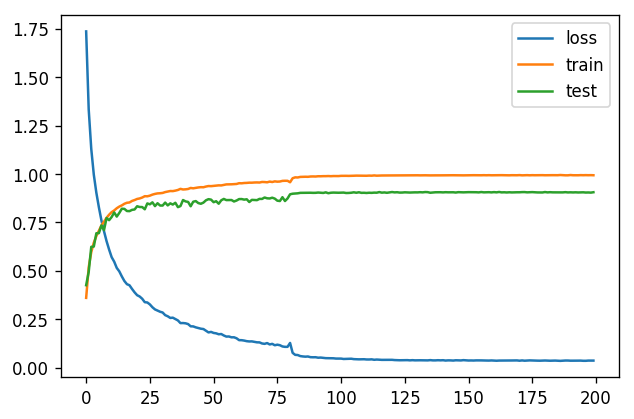

In [ ]:

num_epochs = 100
Train_stu = True
if Train_stu:
    train(rs8, train_data, valid_data, num_epochs, lr, wd, ctx, lr_decay)


In [24]:
rs8.save_params('./model_compression/stu_rs8_90.params')

**中间层训练学生网络**

计算指标

In [21]:
# 计算批量归一化
def batch_norm(X, gamma, beta , moving_mean, moving_variance,is_training = True,
               eps = 1e-5, moving_momentum = 0.9):
    assert len(X.shape) in (2, 4)
    # 全连接: batch_size x feature
    if len(X.shape) == 2:
        # 每个输入维度在样本上的平均和方差
        mean = X.mean(axis=0)
        variance = ((X - mean)**2).mean(axis=0)
    # 2D卷积: batch_size x channel x height x width
    else:
        # 对每个通道算均值和方差，需要保持4D形状使得可以正确的广播
        mean = X.mean(axis=(0,2,3), keepdims=True)
        variance = ((X - mean)**2).mean(axis=(0,2,3), keepdims=True)
        # 变形使得可以正确的广播
        moving_mean = moving_mean.reshape(mean.shape)
        moving_variance = moving_variance.reshape(mean.shape)

    # 均一化
    if is_training:
        X_hat = (X - mean) / nd.sqrt(variance + eps)
        #!!! 更新全局的均值和方差
        moving_mean[:] = moving_momentum * moving_mean + (
            1.0 - moving_momentum) * mean
        moving_variance[:] = moving_momentum * moving_variance + (
            1.0 - moving_momentum) * variance
    else:
        #!!! 测试阶段使用全局的均值和方差
        X_hat = (X - moving_mean) / nd.sqrt(moving_variance + eps)

    # 拉升和偏移
    return gamma.reshape(mean.shape) * X_hat + beta.reshape(mean.shape)



def cal_fsp(resnet,i,x):
    pre_net = resnet[:i]
    net = resnet[i]
    out = x
    for l in pre_net:
        out = l(out)
    
    first = out
    for _,b in enumerate(net[0].net[:4]):
        first = b(first)
    for i,b in enumerate(net):
        out = b(out)
    #print(out.shape)
    (num,channel,h,w) = out.shape

#     weight_scale = 1
#     gamma = nd.random.normal(shape=channel, scale=weight_scale, ctx=ctx)
#     beta = nd.random.normal(shape=channel, scale=weight_scale, ctx=ctx)
#     moving_mean = nd.zeros(channel, ctx=ctx)
#     moving_variance = nd.zeros(channel, ctx=ctx)

    result = out - first
    result = nd.sum(result,axis=[2,3])
    #result = batch_norm(result,gamma,beta,moving_mean,moving_variance)
    result = nd.sigmoid(result)*10

    return result



训练方法

In [22]:

def train2(net_stu, net_tea, train_data,loss_stu, ctx,num_epochs, lr, layer):
    trainer = gluon.Trainer(
        net_stu.collect_params(), 'sgd', {'learning_rate': lr})
    print("Start training on ", ctx)
    train_accs = []
    test_accs = []
    losses_all = []
    criterion = gluon.loss.L2Loss()

    prev_time = datetime.datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        correct = 0
        total = 0
#         if epoch == 25 or epoch == 60:
#             trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for data, label in train_data:
            bs = data.shape[0]
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output_stu = loss_stu(net_stu,layer,data)
                output_tea = loss_stu(net_tea,layer,data)
                loss = criterion(output_stu, output_tea)
            loss.backward()
            trainer.step(bs)
            train_loss += nd.mean(loss).asscalar()

        #writer.add_scalars('loss', {'train': train_loss / len(train_data)}, epoch)
        #writer.add_scalars('acc', {'train': correct / total}, epoch)
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)

        epoch_str = ("Epoch %d. Loss: %f, "% (epoch, train_loss / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str + ', lr ' + str(trainer.learning_rate))


In [35]:
rs8 = Resnet8(10)
ctx = try_gpu()
rs8.initialize(ctx=ctx, init=mx.initializer.Xavier())
rs8.hybridize()

In [36]:
lrs = [0.1,0.1,0.01]
steps = [60,40,100]
net_tea = model.net
loss_stu = cal_fsp
for j in range(2):
    lr = lrs[j]
    step = steps[j]
    for i,net_stu in enumerate([rs8.net1,rs8.net2,rs8.net3]):
    #for i,net_stu in enumerate([rs8.net1]):
        print("begin training %d"%(i))
        train2(net_stu,net_tea,train_data, loss_stu, ctx, num_epochs=step,layer=i+1,lr=lr )
        print("end training %d"%(i))

begin training 0
('Start training on ', gpu(0))
Epoch 0. Loss: 3.064338, Time 00:00:53, lr 0.1
Epoch 1. Loss: 2.802706, Time 00:00:58, lr 0.1
Epoch 2. Loss: 2.852211, Time 00:01:12, lr 0.1
Epoch 3. Loss: 2.719456, Time 00:01:17, lr 0.1
Epoch 4. Loss: 2.637546, Time 00:01:22, lr 0.1
Epoch 5. Loss: 2.569699, Time 00:01:24, lr 0.1
Epoch 6. Loss: 2.586847, Time 00:01:23, lr 0.1
Epoch 7. Loss: 2.585457, Time 00:01:27, lr 0.1
Epoch 8. Loss: 2.579832, Time 00:01:29, lr 0.1
Epoch 9. Loss: 2.576618, Time 00:01:31, lr 0.1
Epoch 10. Loss: 2.602589, Time 00:01:27, lr 0.1
Epoch 11. Loss: 2.584162, Time 00:01:25, lr 0.1
Epoch 12. Loss: 2.567233, Time 00:01:31, lr 0.1
Epoch 13. Loss: 2.589212, Time 00:01:28, lr 0.1
Epoch 14. Loss: 2.658751, Time 00:01:27, lr 0.1
Epoch 15. Loss: 2.674524, Time 00:01:29, lr 0.1
Epoch 16. Loss: 2.673992, Time 00:01:29, lr 0.1
Epoch 17. Loss: 2.647172, Time 00:01:28, lr 0.1
Epoch 18. Loss: 2.683388, Time 00:01:26, lr 0.1
Epoch 19. Loss: 2.647404, Time 00:01:27, lr 0.1
Ep

Epoch 48. Loss: 6.503257, Time 00:01:33, lr 0.1
Epoch 49. Loss: 6.475366, Time 00:01:34, lr 0.1
Epoch 50. Loss: 6.395730, Time 00:01:32, lr 0.1
Epoch 51. Loss: 6.336353, Time 00:01:34, lr 0.1
Epoch 52. Loss: 6.293529, Time 00:01:32, lr 0.1
Epoch 53. Loss: 6.250013, Time 00:01:34, lr 0.1
Epoch 54. Loss: 6.178223, Time 00:01:32, lr 0.1
Epoch 55. Loss: 6.633957, Time 00:01:30, lr 0.1
Epoch 56. Loss: 7.166979, Time 00:01:34, lr 0.1
Epoch 57. Loss: 6.320814, Time 00:01:30, lr 0.1
Epoch 58. Loss: 6.237299, Time 00:01:31, lr 0.1
Epoch 59. Loss: 6.083760, Time 00:01:35, lr 0.1
end training 2
begin training 0
('Start training on ', gpu(0))
Epoch 0. Loss: 3.002946, Time 00:01:32, lr 0.1
Epoch 1. Loss: 2.676504, Time 00:01:30, lr 0.1
Epoch 2. Loss: 2.643167, Time 00:01:28, lr 0.1
Epoch 3. Loss: 2.707390, Time 00:01:30, lr 0.1
Epoch 4. Loss: 2.719664, Time 00:01:27, lr 0.1
Epoch 5. Loss: 2.726743, Time 00:03:07, lr 0.1
Epoch 6. Loss: 2.749880, Time 00:01:30, lr 0.1
Epoch 7. Loss: 2.711694, Time 00

**最后的训练**

In [30]:
def softCE(pred1,pred2,label):
    loss = gluon.loss.SoftmaxCELoss()
    return loss(pred1,label)

def kl_hard_loss(pred1,pred2,label=None):
    loss1 = gluon.loss.KLDivLoss()
    loss2 = gluon.loss.SoftmaxCELoss()
    
    T = 8
    lamda = 0.7
    if label is None:
        return loss1(nd.log_softmax(pred1/T),nd.softmax(pred2/T))*T*T*2 
    return loss1(nd.log_softmax(pred1/T),nd.softmax(pred2/T))*T*T*2*lamda + loss2(pred1,label)*(1-lamda)

In [31]:
criterion = kl_hard_loss
def train3(train_data, valid_data, net_tea, net_stu, num_epochs, lr, wd, ctx, lr_decay):
    trainer = gluon.Trainer(
        net_stu.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    print("Start training on ", ctx)
    train_accs = []
    test_accs = []
    losses_all = []

    prev_time = datetime.datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        correct = 0
        total = 0
        if epoch == 60 or epoch == 150:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for data, label in train_data:
            bs = data.shape[0]
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net_stu(data)
                output_tea = net_tea(data)
                loss = criterion(output, output_tea, label)
            loss.backward()
            trainer.step(bs)
            train_loss += nd.mean(loss).asscalar()
            correct += get_acc(output, label)
            total += bs
        #writer.add_scalars('loss', {'train': train_loss / len(train_data)}, epoch)
        #writer.add_scalars('acc', {'train': correct / total}, epoch)
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_correct = 0
            valid_total = 0
            valid_loss = 0
            for data, label in valid_data:
                bs = data.shape[0]
                data = data.as_in_context(ctx)
                label = label.as_in_context(ctx)
                output = net_stu(data)
                loss = softCE(output, None, label)
                valid_loss += nd.mean(loss).asscalar()
                valid_correct += get_acc(output, label)
                valid_total += bs
            valid_acc = valid_correct / valid_total
            #writer.add_scalars('loss', {'valid': valid_loss / len(valid_data)}, epoch)
            #writer.add_scalars('acc', {'valid': valid_acc}, epoch)
            epoch_str = ("Epoch %d. Train Loss: %f, Train acc %f, Valid Loss: %f, Valid acc %f, "
                         % (epoch, train_loss / len(train_data),
                            correct / total, valid_loss / len(valid_data), valid_acc))
            train_accs.append(correct / total)
            test_accs.append(valid_acc)
            losses_all.append(train_loss / len(train_data))
        else:
            epoch_str = ("Epoch %d. Loss: %f, Train acc %f, "
                         % (epoch, train_loss / len(train_data),
                            correct / total))
        prev_time = cur_time
        print(epoch_str + time_str + ', lr ' + str(trainer.learning_rate))
        show = True
    if show==True:
        plt.plot(losses_all)
        plt.plot(train_accs)
        plt.plot(test_accs)
        plt.legend(['loss','train','test'])
        plt.show()

('Start training on ', gpu(0))
Epoch 0. Train Loss: 0.406188, Train acc 0.960267, Valid Loss: 0.417997, Valid acc 0.905400, Time 00:01:01, lr 0.01
Epoch 1. Train Loss: 0.404267, Train acc 0.959489, Valid Loss: 0.412011, Valid acc 0.904800, Time 00:01:05, lr 0.01
Epoch 2. Train Loss: 0.406399, Train acc 0.960867, Valid Loss: 0.424587, Valid acc 0.902200, Time 00:01:06, lr 0.01
Epoch 3. Train Loss: 0.402762, Train acc 0.961489, Valid Loss: 0.417390, Valid acc 0.907200, Time 00:01:18, lr 0.01
Epoch 4. Train Loss: 0.403489, Train acc 0.960467, Valid Loss: 0.421503, Valid acc 0.904400, Time 00:01:23, lr 0.01
Epoch 5. Train Loss: 0.402214, Train acc 0.961178, Valid Loss: 0.423728, Valid acc 0.905200, Time 00:01:26, lr 0.01
Epoch 6. Train Loss: 0.401868, Train acc 0.961844, Valid Loss: 0.428485, Valid acc 0.906400, Time 00:01:29, lr 0.01
Epoch 7. Train Loss: 0.403190, Train acc 0.961933, Valid Loss: 0.418662, Valid acc 0.908000, Time 00:01:30, lr 0.01
Epoch 8. Train Loss: 0.399416, Train acc 

Epoch 70. Train Loss: 0.353769, Train acc 0.972222, Valid Loss: 0.412427, Valid acc 0.906200, Time 00:01:41, lr 0.001
Epoch 71. Train Loss: 0.353723, Train acc 0.972356, Valid Loss: 0.418104, Valid acc 0.906600, Time 00:01:40, lr 0.001
Epoch 72. Train Loss: 0.352735, Train acc 0.972822, Valid Loss: 0.411494, Valid acc 0.908600, Time 00:01:39, lr 0.001
Epoch 73. Train Loss: 0.355183, Train acc 0.973133, Valid Loss: 0.408538, Valid acc 0.907200, Time 00:01:39, lr 0.001
Epoch 74. Train Loss: 0.354972, Train acc 0.972289, Valid Loss: 0.407518, Valid acc 0.907600, Time 00:01:38, lr 0.001
Epoch 75. Train Loss: 0.354144, Train acc 0.972733, Valid Loss: 0.412593, Valid acc 0.907800, Time 00:01:40, lr 0.001
Epoch 76. Train Loss: 0.352240, Train acc 0.972311, Valid Loss: 0.410196, Valid acc 0.909400, Time 00:01:39, lr 0.001
Epoch 77. Train Loss: 0.353756, Train acc 0.973111, Valid Loss: 0.414278, Valid acc 0.907200, Time 00:01:39, lr 0.001
Epoch 78. Train Loss: 0.352086, Train acc 0.972733, Vali

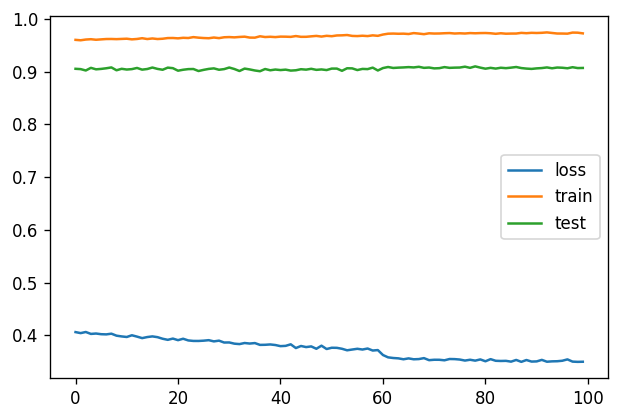

In [38]:
num_epochs = 100
lr = 0.01
wd = 1e-4
lr_decay = 0.1
net_tea = model.net
train3(train_data, valid_data, net_tea, rs8.net, num_epochs, lr, wd, ctx, lr_decay)

下面是用kd法得出的结果



In [ ]:
num_epochs = 100
lr = 0.1
wd = 1e-4
lr_decay = 0.1
net_tea = model.net
train3(train_data, valid_data, net_tea, rs8.net, num_epochs, lr, wd, ctx, lr_decay)

In [33]:
rs8.save_params("./model_compression/rs8_kd_916.params")

In [34]:
ll ./model_compression/rs8_kd_916.params

ls: 初始化月份字符串出错
-rw-rw-r-- 1 dragon 1244832 3鏈�22 11:30 ./model_compression/rs8_kd_916.params


In [ ]:
# rs8 = Resnet8(10)
# ctx = try_gpu()
# rs8.initialize(ctx=ctx, init=mx.initializer.Xavier())
# rs8.hybridize()


num_epochs = 300
lr = 0.1
wd = 1e-4
lr_decay = 0.1
net_tea = model.net
train3(train_data, valid_data, net_tea, rs8.net, num_epochs, lr, wd, ctx, lr_decay)

('Start training on ', gpu(0))
Epoch 0. Train Loss: 2.649419, Train acc 0.434133, Valid Loss: 102.727097, Valid acc 0.561600, Time 00:01:10, lr 0.1
Epoch 1. Train Loss: 1.883392, Train acc 0.612578, Valid Loss: 112.421202, Valid acc 0.644800, Time 00:01:12, lr 0.1
Epoch 2. Train Loss: 1.553128, Train acc 0.686111, Valid Loss: 105.778873, Valid acc 0.638600, Time 00:01:13, lr 0.1
Epoch 3. Train Loss: 1.360003, Train acc 0.730622, Valid Loss: 109.496164, Valid acc 0.648000, Time 00:01:13, lr 0.1
Epoch 4. Train Loss: 1.203257, Train acc 0.763800, Valid Loss: 117.274612, Valid acc 0.754800, Time 00:01:13, lr 0.1
Epoch 5. Train Loss: 1.075489, Train acc 0.791267, Valid Loss: 125.142658, Valid acc 0.769600, Time 00:01:11, lr 0.1
Epoch 6. Train Loss: 0.990930, Train acc 0.811444, Valid Loss: 123.690585, Valid acc 0.782000, Time 00:01:11, lr 0.1
Epoch 7. Train Loss: 0.915612, Train acc 0.826467, Valid Loss: 130.502892, Valid acc 0.810800, Time 00:01:12, lr 0.1
Epoch 8. Train Loss: 0.856946, Tr

Epoch 74. Train Loss: 0.360285, Train acc 0.949756, Valid Loss: 132.321304, Valid acc 0.865000, Time 00:01:10, lr 0.1
Epoch 75. Train Loss: 0.359434, Train acc 0.950467, Valid Loss: 128.457849, Valid acc 0.871800, Time 00:01:12, lr 0.1
Epoch 76. Train Loss: 0.349274, Train acc 0.953044, Valid Loss: 131.468816, Valid acc 0.880000, Time 00:01:12, lr 0.1
Epoch 77. Train Loss: 0.351334, Train acc 0.952711, Valid Loss: 132.905311, Valid acc 0.864000, Time 00:01:12, lr 0.1
Epoch 78. Train Loss: 0.341745, Train acc 0.955156, Valid Loss: 134.539066, Valid acc 0.858800, Time 00:01:12, lr 0.1
Epoch 79. Train Loss: 0.357052, Train acc 0.951578, Valid Loss: 122.268816, Valid acc 0.854600, Time 00:01:08, lr 0.1
Epoch 80. Train Loss: 0.307888, Train acc 0.964200, Valid Loss: 134.881367, Valid acc 0.909200, Time 00:01:06, lr 0.01
Epoch 81. Train Loss: 0.260774, Train acc 0.975067, Valid Loss: 134.838368, Valid acc 0.911800, Time 00:01:11, lr 0.01
Epoch 82. Train Loss: 0.250817, Train acc 0.976889, Va

Epoch 147. Train Loss: 0.194562, Train acc 0.990756, Valid Loss: 134.938135, Valid acc 0.914000, Time 00:01:10, lr 0.01
Epoch 148. Train Loss: 0.192886, Train acc 0.990778, Valid Loss: 133.870513, Valid acc 0.915200, Time 00:01:12, lr 0.01
Epoch 149. Train Loss: 0.192657, Train acc 0.990956, Valid Loss: 134.390115, Valid acc 0.914600, Time 00:01:13, lr 0.01
Epoch 150. Train Loss: 0.192895, Train acc 0.991156, Valid Loss: 134.444393, Valid acc 0.913800, Time 00:01:12, lr 0.01
Epoch 151. Train Loss: 0.192731, Train acc 0.990689, Valid Loss: 133.891526, Valid acc 0.914600, Time 00:01:13, lr 0.01
Epoch 152. Train Loss: 0.190249, Train acc 0.992311, Valid Loss: 134.998227, Valid acc 0.913400, Time 00:01:13, lr 0.01
Epoch 153. Train Loss: 0.190434, Train acc 0.990644, Valid Loss: 134.895196, Valid acc 0.918000, Time 00:01:10, lr 0.01
Epoch 154. Train Loss: 0.191604, Train acc 0.991489, Valid Loss: 134.259409, Valid acc 0.912200, Time 00:01:13, lr 0.01
Epoch 155. Train Loss: 0.191639, Train a

Epoch 222. Train Loss: 0.172029, Train acc 0.994822, Valid Loss: 134.361674, Valid acc 0.913600, Time 00:01:08, lr 0.001
Epoch 223. Train Loss: 0.174218, Train acc 0.994000, Valid Loss: 134.582973, Valid acc 0.914400, Time 00:01:10, lr 0.001
Epoch 224. Train Loss: 0.172892, Train acc 0.994600, Valid Loss: 133.996674, Valid acc 0.915200, Time 00:01:09, lr 0.001
Epoch 225. Train Loss: 0.172021, Train acc 0.994400, Valid Loss: 134.366277, Valid acc 0.915400, Time 00:01:08, lr 0.001
Epoch 226. Train Loss: 0.172553, Train acc 0.994089, Valid Loss: 134.050806, Valid acc 0.915200, Time 00:01:12, lr 0.001
Epoch 227. Train Loss: 0.172417, Train acc 0.994511, Valid Loss: 134.560164, Valid acc 0.914200, Time 00:01:13, lr 0.001
Epoch 228. Train Loss: 0.171565, Train acc 0.994822, Valid Loss: 134.446181, Valid acc 0.914000, Time 00:01:12, lr 0.001
Epoch 229. Train Loss: 0.171871, Train acc 0.995067, Valid Loss: 134.207635, Valid acc 0.915400, Time 00:01:11, lr 0.001
Epoch 230. Train Loss: 0.173317,

In [ ]:
rs8.save_params('./model_compression/stu_rs4_kd73.params')

In [32]:
test(rs8,valid_data)

Valid Loss: 134.386126, Valid acc 0.916000Time 00:00:03
